In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow.compat.v1 as tf
from tensorflow.contrib.opt import ScipyOptimizerInterface
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import random
import sys
np.set_printoptions(threshold=sys.maxsize)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
class DNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2/(in_dim + out_dim))
            weight = tf.Variable(tf.random_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y


In [3]:
n = 0
LOSS = []
LOSS_LF = []
LOSS_HF = []
def callback(loss_,loss_lf_,loss_hf_):
    global n
    global LOSS
    global LOSS_LF
    global LOSS_HF
    LOSS = np.hstack((LOSS,loss_))
    LOSS_LF = np.hstack((LOSS_LF,loss_lf_))
    LOSS_HF = np.hstack((LOSS_HF,loss_hf_))
    n += 1
    if n%1000 == 0:
        print('n: %d, loss: %.3e, loss_lf: %.3e, loss_hf: %.3e'%(n, loss_, loss_lf_, loss_hf_))

In [4]:
YH1_train = np.genfromtxt('Vis_Train_H.txt')
XH1_train = np.genfromtxt('ExT_Train_H.txt')
XH2_train = np.genfromtxt('Shr_Train_H.txt')

YH1_train = YH1_train.reshape((-1,1))
XH1_train = XH1_train.reshape((-1,1))
XH2_train = XH2_train.reshape((-1,1))

In [5]:
YH1_test = np.genfromtxt('Vis_Test_H.txt')
XH1_test = np.genfromtxt('ExT_Test_H.txt')
XH2_test = np.genfromtxt('Shr_Test_H.txt')

YH1_test = YH1_test.reshape((-1,1))
XH1_test = XH1_test.reshape((-1,1))
XH2_test = XH2_test.reshape((-1,1))

In [6]:
YL1_train = np.genfromtxt('Vis_L.txt')
XL1_train = np.genfromtxt('ExT_L.txt')
XL2_train = np.genfromtxt('Shr_L.txt')

y_lf = ((np.random.normal(1,0.025,len(YL1_train))) * YL1_train).reshape(1,-1).T
x_lf = ((np.random.normal(1,0.025,len(XL1_train))) * XL1_train).reshape(1,-1).T
t_lf = ((np.random.normal(1,0.025,len(XL2_train))) * XL2_train).reshape(1,-1).T

X_lf = np.hstack((x_lf,t_lf))

In [7]:
y_hf = YH1_train.reshape(1,-1).T
x_hf = XH1_train.reshape(1,-1).T
t_hf = XH2_train.reshape(1,-1).T

X_hf = np.hstack((x_hf,t_hf))

Xmin = X_hf.min(0)
Xmax = X_hf.max(0)
Ymin = y_hf.min(0)
Ymax = y_hf.max(0)

Xhmin = np.hstack((Xmin, Ymin))
Xhmax = np.hstack((Xmax, Ymax))

In [8]:
D = 2
layers_lf = [D] + 2*[20] + [1]
layers_hf_nl = [D+1] + 2*[10] + [1]
layers_hf_l = [D+1] + [1]

x_train_lf = tf.placeholder(shape=[None, D], dtype=tf.float32)
y_train_lf = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x_train_hf = tf.placeholder(shape=[None, D], dtype=tf.float32)
y_train_hf = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [9]:
model = DNN()
W_lf, b_lf = model.hyper_initial(layers_lf)
W_hf_nl, b_hf_nl = model.hyper_initial(layers_hf_nl)
W_hf_l, b_hf_l = model.hyper_initial(layers_hf_l)

y_pred_lf = model.fnn(W_lf, b_lf, x_train_lf, Xmin, Xmax)
#low-fidelity values to serve as the input for the high-fidelity NN
y_pred_lf_hf = model.fnn(W_lf, b_lf, x_train_hf, Xmin, Xmax)
#nonlinear part with two inputs (x_H, y_l(x_H))
y_pred_hf_nl = model.fnn(W_hf_nl, b_hf_nl, tf.concat([x_train_hf, y_pred_lf_hf], 1), Xhmin, Xhmax)
#linear part with two inputs (x_H, y_l(x_H))
y_pred_hf_l = model.fnn(W_hf_l, b_hf_l, tf.concat([x_train_hf, y_pred_lf_hf], 1), Xhmin, Xhmax)
y_pred_hf = y_pred_hf_l + y_pred_hf_nl

In [10]:
loss_l2 = tf.add_n([tf.nn.l2_loss(w_) for w_ in W_hf_nl])
loss_lf = tf.reduce_mean((tf.square(y_pred_lf - y_train_lf)))
loss_hf =  tf.reduce_mean((tf.square(y_pred_hf - y_train_hf)))
loss = loss_lf + loss_hf + loss_l2
train_adam = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
train_lbfgs = ScipyOptimizerInterface(loss,
                                      method = 'L-BFGS-B', 
                                      options={'maxiter': 50000,
                                               'ftol': 1.0*np.finfo(float).eps
                                              })

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

### Compile the cell below just only for model loading

In [12]:
#model = saver.restore(sess, 'MPINNModel/MPINN_Model')

In [13]:
#nmax1 = 2000
#nmax2 = 20000
#loss_c = 1.0e-6
loss_ = 1.0
train_dict = {x_train_lf: X_lf, y_train_lf: y_lf, x_train_hf: X_hf, y_train_hf: y_hf}
print('Adam Optimizer')
while n < 20000 and loss_ > 1e-6:
    n += 1
    loss_, _, loss_lf_, loss_hf_ = sess.run([loss, train_adam, loss_lf, loss_hf], feed_dict=train_dict)
    LOSS = np.hstack((LOSS,loss_))
    LOSS_LF = np.hstack((LOSS_LF,loss_lf_))
    LOSS_HF = np.hstack((LOSS_HF,loss_hf_))
    if n%1000 == 0:
        print('n: %d, loss: %.3e, loss_lf: %.3e, loss_hf: %.3e'%(n, loss_, loss_lf_, loss_hf_))

print('LBFG-S Optimizer')
train_lbfgs.minimize(sess, feed_dict=train_dict, fetches=[loss, loss_lf, loss_hf], loss_callback=callback)

print("Training is done!")

Adam Optimizer
n: 1000, loss: 1.513e-01, loss_lf: 4.252e-02, loss_hf: 1.560e-02
n: 2000, loss: 2.686e-02, loss_lf: 1.829e-02, loss_hf: 8.339e-03
n: 3000, loss: 2.101e-02, loss_lf: 1.319e-02, loss_hf: 7.812e-03
n: 4000, loss: 1.864e-02, loss_lf: 1.089e-02, loss_hf: 7.750e-03
n: 5000, loss: 1.827e-02, loss_lf: 1.018e-02, loss_hf: 8.081e-03
n: 6000, loss: 1.747e-02, loss_lf: 8.587e-03, loss_hf: 8.886e-03
n: 7000, loss: 1.517e-02, loss_lf: 6.741e-03, loss_hf: 8.432e-03
n: 8000, loss: 9.795e-03, loss_lf: 6.612e-03, loss_hf: 3.183e-03
n: 9000, loss: 9.721e-03, loss_lf: 6.568e-03, loss_hf: 3.153e-03
n: 10000, loss: 9.704e-03, loss_lf: 6.552e-03, loss_hf: 3.152e-03
n: 11000, loss: 9.691e-03, loss_lf: 6.544e-03, loss_hf: 3.146e-03
n: 12000, loss: 9.676e-03, loss_lf: 6.537e-03, loss_hf: 3.138e-03
n: 13000, loss: 9.661e-03, loss_lf: 6.531e-03, loss_hf: 3.130e-03
n: 14000, loss: 9.648e-03, loss_lf: 6.526e-03, loss_hf: 3.121e-03
n: 15000, loss: 9.659e-03, loss_lf: 6.533e-03, loss_hf: 3.126e-03
n: 1

In [14]:
LOSS[20001] = LOSS[20000]
LOSS_LF[20001] = LOSS_LF[20000]
LOSS_HF[20001] = LOSS_HF[20000]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


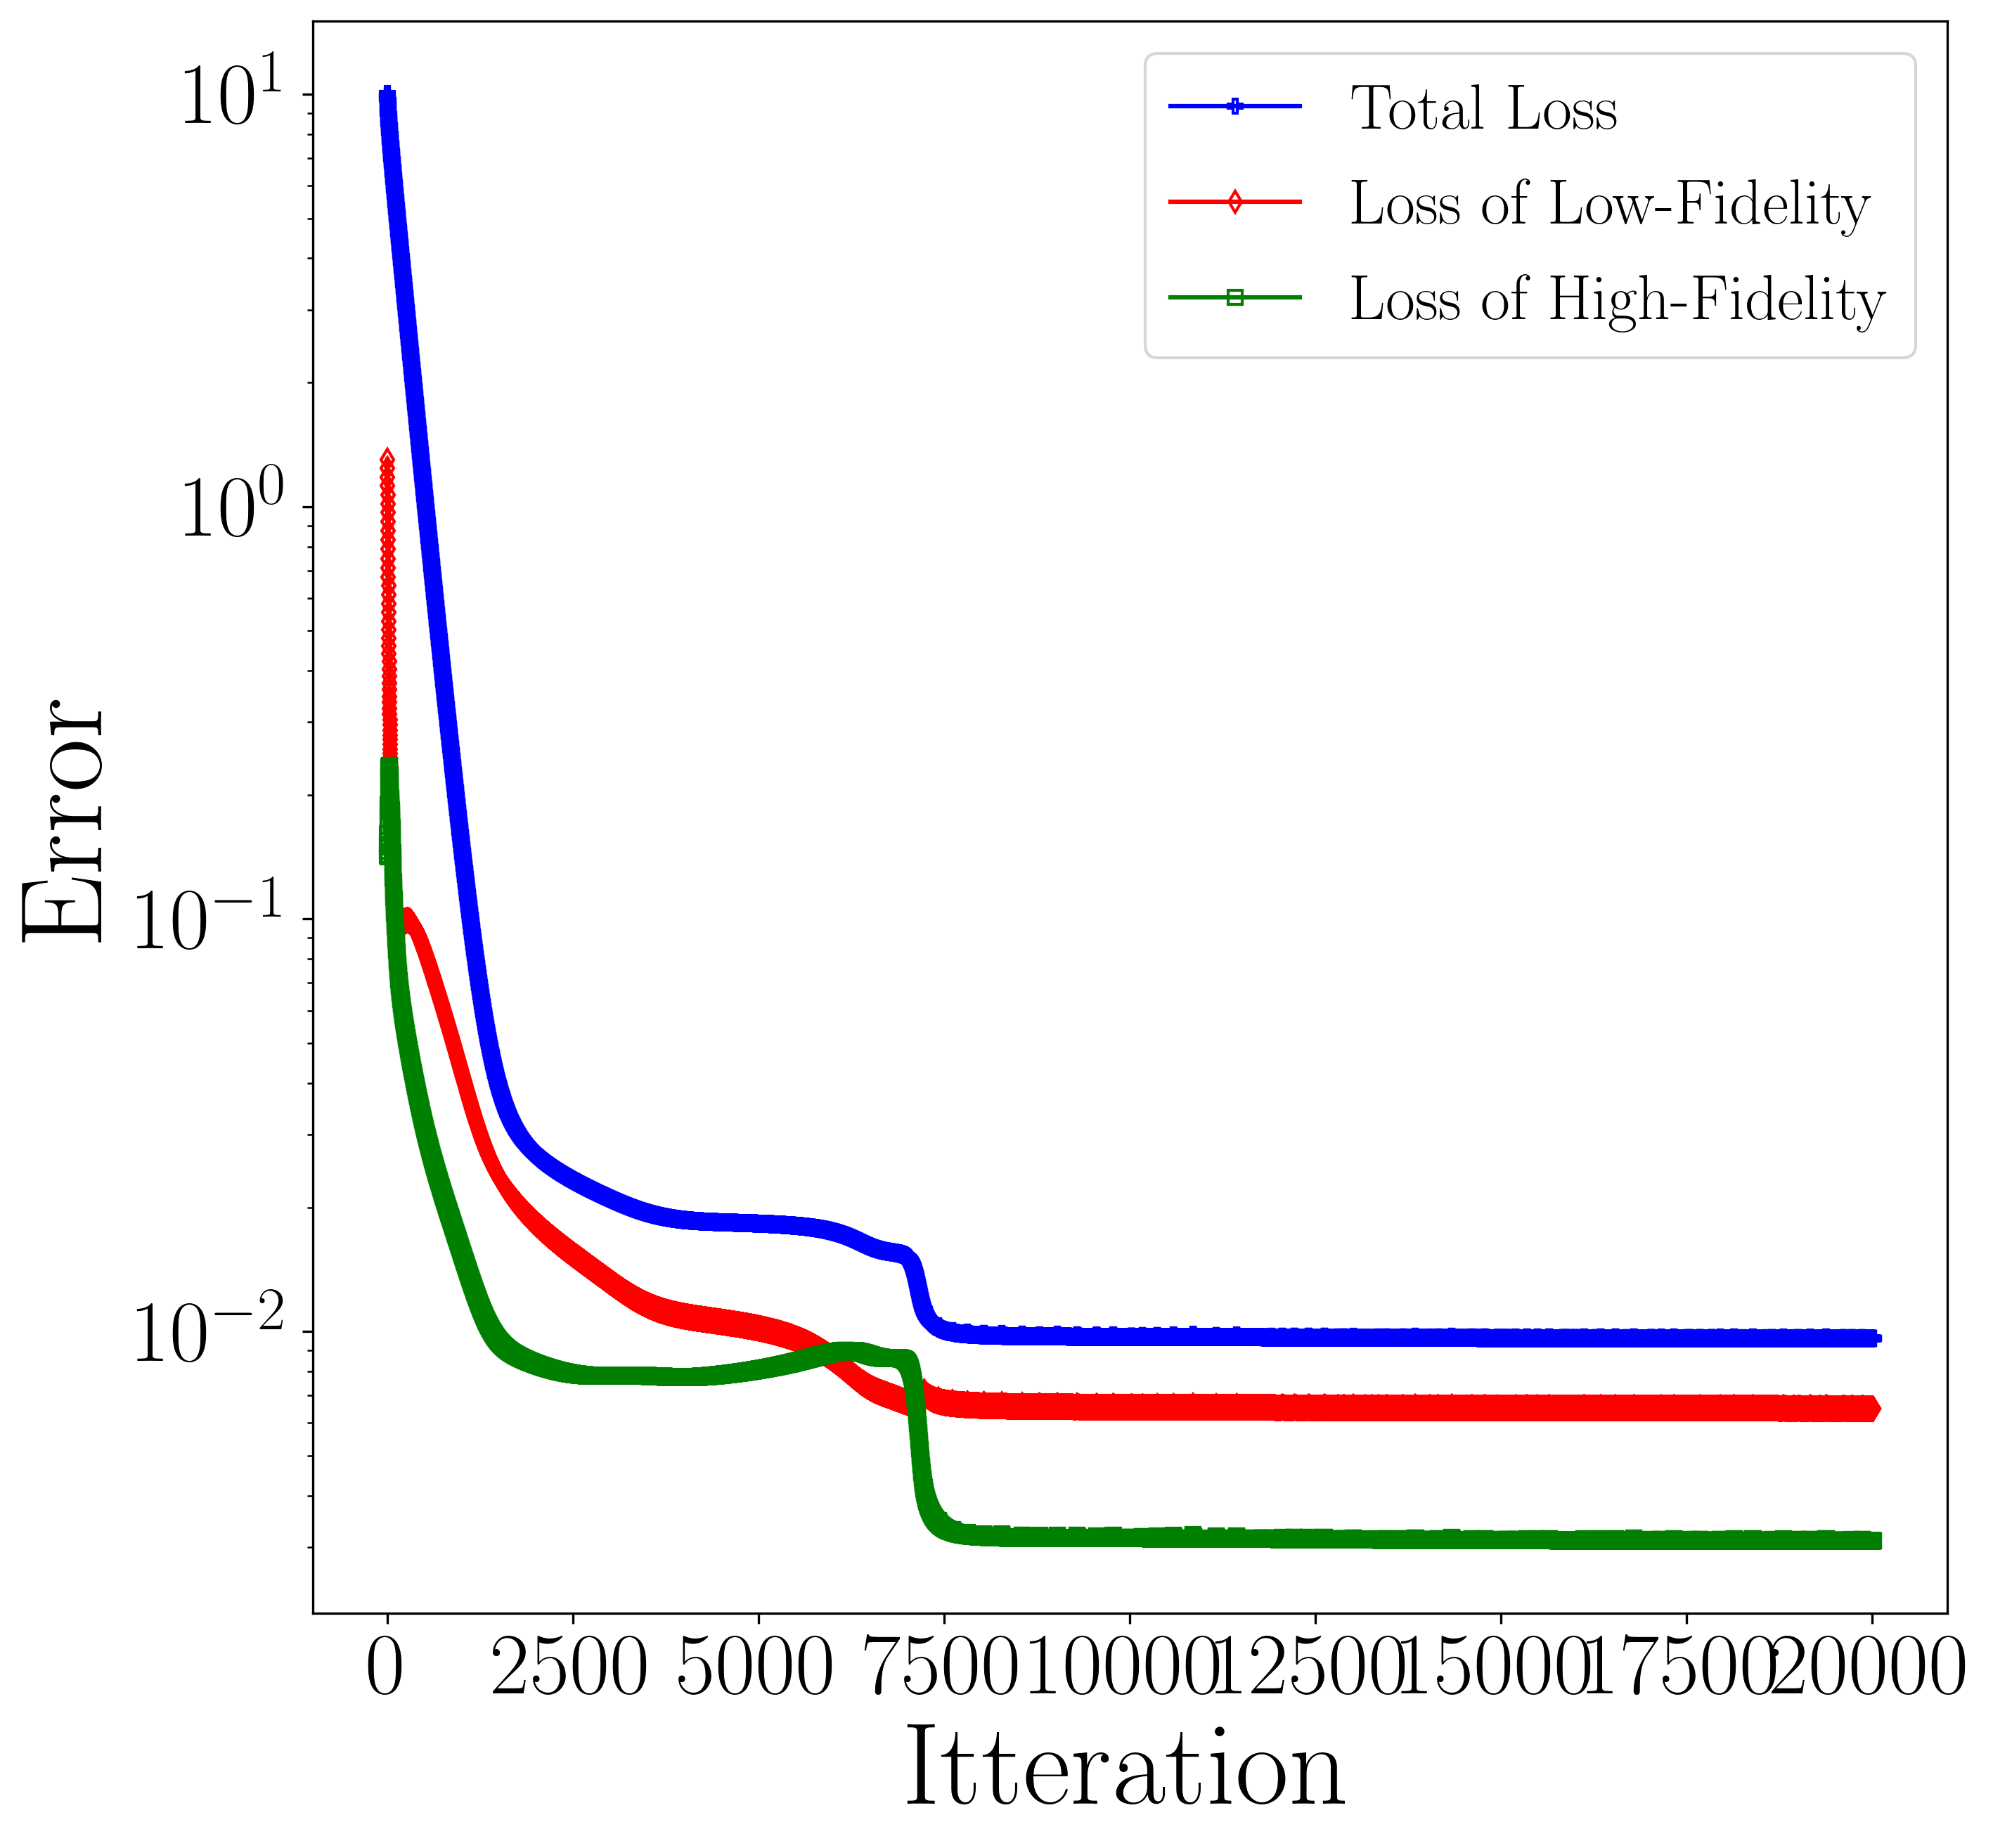

In [15]:
import matplotlib.font_manager
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.figure(figsize=(10,10),dpi=300)

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(LOSS[0:62000] , 'bP-', markerfacecolor='none', linewidth=1.5, markersize = 5.0)
plt.plot(LOSS_LF[0:62000] , 'rd-', markerfacecolor='none', linewidth=1.5, markersize = 5.0)
plt.plot(LOSS_HF [0:62000], 'gs-' , markerfacecolor='none', linewidth=1.5, markersize = 5.0)

plt.xlabel('Itteration', fontname = 'Times New Roman', fontsize=40)
plt.ylabel('Error', fontname = 'Times New Roman', fontsize=40)
plt.legend(['Total Loss','Loss of Low-Fidelity','Loss of High-Fidelity'],loc='upper right')
#plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xticks(fontname = "Times New Roman", fontsize=30)
plt.yticks(fontname = "Times New Roman", fontsize=30)
#plt.ylim(0.6,13)
#plt.xscale("log")
plt.yscale("log")

#plt.savefig('Prediction_Batch09.png',bbox_inches = 'tight')

plt.show()

# Flow Curve

In [ ]:
a=0*42
b=1*42

ShR = np.power(10,XH2_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)
#plt.plot(np.power(10,t_lf[401:442]),np.power(10,y_lf[401:442]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using MPINN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")
plt.yscale("log")

plt.show()

# Regression

In [ ]:
plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(y_hf_ref,y_hf_test, 'kd', linewidth=5.0)
plt.plot(np.linspace(-0.5, 1.5, 100),np.linspace(-0.5, 1.5, 100), 'r--', linewidth=3.0)
plt.xlabel('Actual Data')
plt.ylabel('Predicted Data')
plt.legend(['Actual Regression','Perfect Regression'])
plt.title('Regression Between Actual and Predicted Data')

plt.grid(color='g', linestyle=':', linewidth=1)

#plt.xlim(-0.5, 1.5)
#plt.ylim(-0.5, 1.5)

#plt.text(-4500, 11500, 'Pearson Regression Correlation is 0.94', style='italic',bbox={'facecolor': 'blue', 'alpha': 0.1, 'pad': 5})

#plt.savefig('00 Research Codes/02_Multi_Fidelity/With_Randy/FX1_linear_regression.png')

plt.show()